> 在本例中，使用公式选股并进行回测

In [1]:
%matplotlib inline

import os
import datetime as dt
import pandas as pd
import numpy as np
from PyFin.api import *
from alphamind.api import *
from matplotlib import pyplot as plt

## 1. 参数设置
----------------

* 调仓频率：每周
* 股票池  ：中证800
* 起始日  ：2017-05-31
* 结束日  ：2019-05-31

In [2]:
freq = "1w"
universe = Universe('zz800')
engine = SqlEngine(os.environ['DB_URI'])
start_date = '2017-05-31'
end_date = '2019-05-31'
rebalance_dates = makeSchedule(start_date, end_date, freq, 'china.sse', BizDayConventions.Preceding)

## 2. 选股公式
-----------------------

* 在每个调仓日获取每个行业按照`ETOP`因子排序，最高的3支股票。行业分类使用申万1级

In [3]:
formula = CSTopN(LAST('ETOP'), 3, groups='sw1')

## 3. 计算过程
----------------

* 获取因子值以及行业信息

In [4]:
%%time
factors = engine.fetch_factor_range(universe, {'alpha': formula}, dates=rebalance_dates)
industries = engine.fetch_industry_range(universe, dates=rebalance_dates)

Wall time: 40.7 s


* 因子选股并且进行获取相关股票每日收益

In [5]:
%%time
chosen_stks = factors[factors.alpha == 1.]
codes = chosen_stks.code.unique()
stk_returns = engine.fetch_dx_return_range(universe, start_date, end_date)

Wall time: 21.1 s


* 计算每日调仓结果以及收益

In [6]:
%%time

ret_dates = np.unique(stk_returns.trade_date)
rebalance_dates = chosen_stks.trade_date.unique()

rtn_groups = stk_returns.groupby('trade_date')
industry_groups = industries.groupby('trade_date')
stks_groups = chosen_stks.groupby('trade_date')

portfolio_rtns = []
portfolios = pd.DataFrame(columns=['code', 'weight', 'industry'])

for ref_date, g in rtn_groups:
    ref_date = ref_date.to_datetime64()
    nearest_date = rebalance_dates[rebalance_dates <= ref_date][-1]
    this_codes = stks_groups.get_group(nearest_date)['code'].tolist()
    
    next_day_rtn = g.loc[g.code.isin(this_codes), 'dx'].values
    portfolio_nd_rtn = np.mean(next_day_rtn)
    portfolio_rtns.append(portfolio_nd_rtn)
    if ref_date in rebalance_dates:
        this_industry = industry_groups.get_group(nearest_date).set_index('code')
        this_df = pd.DataFrame(data={'code': this_codes,
                                     'weight': np.ones(len(this_codes)) * 1. / len(this_codes),
                                     'industry': this_industry.loc[this_codes, 'industry'].values})
        this_df.index =[ref_date] * len(this_codes)
        portfolios = portfolios.append(this_df)

portfolio_rtns = pd.DataFrame({'ret': portfolio_rtns}, index=ret_dates)

Wall time: 1.24 s


## 4. 表现展示
-------------------

### 4.1 日收益与回撤

In [7]:
from PyFin.Math.Accumulators import MovingDrawdown

In [14]:
%%time
mv = MovingDrawdown(window=1000, x='ret')
dds = []

for r in portfolio_rtns['ret'].values:
    mv.push({'ret': r})
    dds.append(mv.value)

portfolio_rtns['dd.'] = dds

Wall time: 1 ms


(-0.6, 0.3)

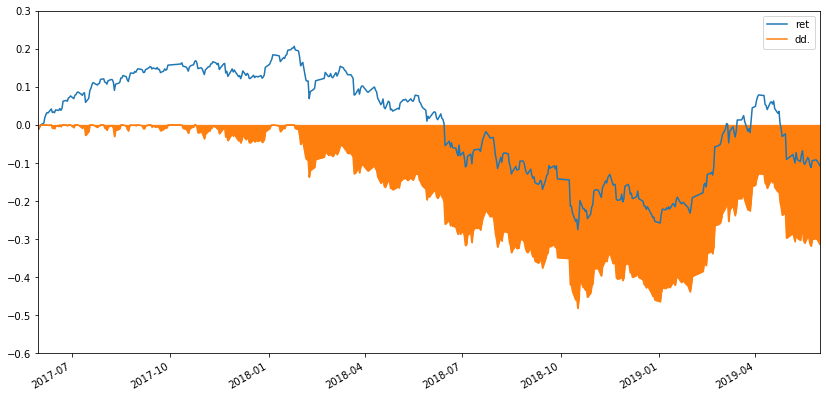

In [15]:
portfolio_rtns['ret'].cumsum().plot(figsize=(14, 7))
portfolio_rtns['dd.'].plot(kind='area')
plt.legend(['ret', 'dd.'])
plt.ylim([-0.6, 0.3])

### 4.2 月度收益

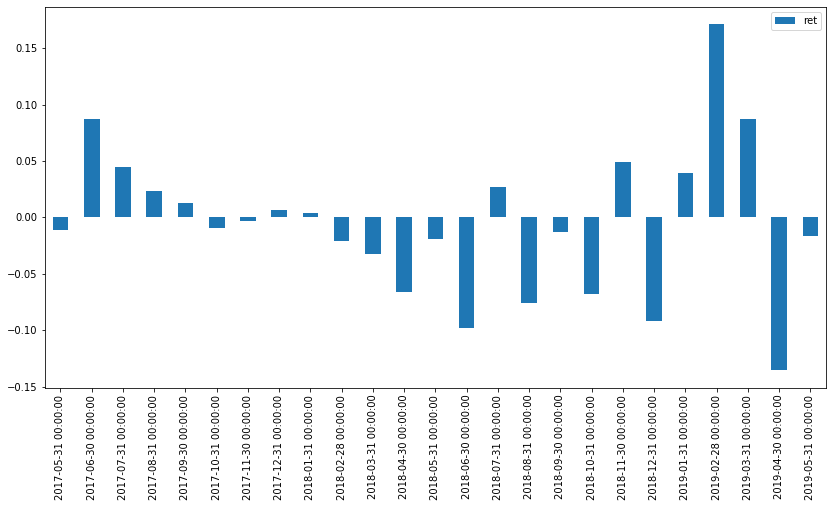

In [16]:
portfolio_rtns['ret'].resample('M').sum().plot(figsize=(14, 7), kind='bar')
plt.legend(['ret'])

### 4.3 行业分布

In [19]:
portfolios.reset_index().groupby(['index', 'industry']).count()

code  weight
index      industry              
2017-05-31 交通运输         2       2
           休闲服务         3       3
           传媒           2       2
           公用事业         2       2
           农林牧渔         3       3
           化工           3       3
           医药生物         3       3
           商业贸易         3       3
           国防军工         2       2
           家用电器         3       3
           建筑材料         3       3
           建筑装饰         3       3
           房地产          3       3
           有色金属         2       2
           机械设备         2       2
           汽车           3       3
           电子           3       3
           电气设备         3       3
           纺织服装         2       2
           综合           3       3
           计算机          3       3
           轻工制造         3       3
           通信           3       3
           采掘           3       3
           钢铁           1       1
           银行           3       3
           非银金融         3       3
           食品饮料         3       3
2017-06-07 交通运输         2       2
           休闲服务         3       3
...                   ...     ...
2019-05-29 非银金融         3       3
           食品饮料         3       3
2019-05-31 交通运输         3       3
           休闲服务         3       3
           传媒           3       3
           公用事业         2       2
           农林牧渔         2       2
           化工           2       2
           医药生物         2       2
           商业贸易         2       2
           国防军工         3       3
           家用电器         3       3
           建筑材料         3       3
           建筑装饰         3       3
           房地产          3       3
           有色金属         3       3
           机械设备         3       3
           汽车           3       3
           电子           3       3
           电气设备         3       3
           纺织服装         1       1
           综合           3       3
           计算机          3       3
           轻工制造         3       3
           通信           3       3
           采掘           3       3
           钢铁           3       3
           银行           3       3
           非银金融         3       3
           食品饮料         3       3

[2939 rows x 2 columns]